## 1-Parameter Optimization Parameters with PINNs
Following this [tutorial](https://docs.sciml.ai/NeuralPDE/dev/tutorials/param_estim/) with additional annotations because I don't understand the code (yet)

In [2]:
# Packages
using Pkg
Pkg.activate("../../PINN")

using NeuralPDE, Lux, ModelingToolkit, Optimization, OptimizationOptimJL, OrdinaryDiffEq, Plots, DifferentialEquations, Zygote
import ModelingToolkit: Interval, infimum, supremum

  Activating project at `~/SURE2023/scientific_julia/PINN`


┌ Warning: Error requiring `Zygote` from `SparseDiffTools`
│   exception = (LoadError("/home/jennifertramsu/.julia/packages/SparseDiffTools/exnrN/ext/SparseDiffToolsZygote.jl", 1, ArgumentError("Package SparseDiffTools does not have Zygote in its dependencies:\n- You may have a partially installed environment. Try `Pkg.instantiate()`\n  to ensure all packages in the environment are installed.\n- Or, if you have SparseDiffTools checked out for development and have\n  added Zygote as a dependency but haven't updated your primary\n  environment's manifest file, try `Pkg.resolve()`.\n- Otherwise you may need to report an issue with SparseDiffTools")), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007f3156a418de, Ptr{Nothing} @0x00007f3156a41b06, Ptr{Nothing} @0x00007f316c5ecdbd, Ptr{Nothing} @0x00007f316c62ae48, Ptr{Nothing} @0x00007f316c62cf5a, Ptr{Nothing} @0x00007f316c62c607, Ptr{Nothing} @0x00007f316c62c7e8, Ptr{Nothing} @0x00007f316c62dc2a, Ptr{Nothing} @0x00007f31591ecd11

### Defining the ODE System
Below, we define the ODE system using Symbolic packages. The initial conditions `[1, 1/2, 3]` are coded as the system's boundary conditions and the time span is defined as the system's domain from `t=[0.0, 1.5]`. The parameter to be optimized is $\alpha$.

In [132]:
# Defining ODE system
@parameters t, α
@variables x(..), y(..), z(..)
Dt = Differential(t)

eqs = [Dt(x(t)) ~ -x(t) + α*z(t),
    Dt(y(t)) ~ -y(t) + 2*z(t),
    Dt(z(t)) ~ x(t)^2 - 2*z(t)]

bcs = [x(0) ~ 1, y(0) ~ 1/2, z(0) ~ 3]
domains = [t ∈ Interval(0.0, 1.5)]
dt = 0.01 

0.01

### Defining the Neural Network
Systems of ODEs can be solved using the `PhysicsInformedNN` discretizer for PDE systems. Below, we define the architecture of the neural networks. From the universal approximation theorem, each ODE can be represented by a neural network. These are defined below.

In [74]:
# Defining Neural Networks
input_ = length(domains)
n = 8

chain1 = Lux.Chain(Dense(input_, n, Lux.σ), Dense(n, n, Lux.σ), Dense(n, n, Lux.σ), Dense(n, 1)) # dx/dt
chain2 = Lux.Chain(Dense(input_, n, Lux.σ), Dense(n, n, Lux.σ), Dense(n, n, Lux.σ), Dense(n, 1)) # dy/dt
chain3 = Lux.Chain(Dense(input_, n, Lux.σ), Dense(n, n, Lux.σ), Dense(n, n, Lux.σ), Dense(n, 1)) # dz/dt

Chain(
    layer_1 = Dense(1 => 8, sigmoid_fast),  # 16 parameters
    layer_2 = Dense(8 => 8, sigmoid_fast),  # 72 parameters
    layer_3 = Dense(8 => 8, sigmoid_fast),  # 72 parameters
    layer_4 = Dense(8 => 1),            # 9 parameters
)         # Total: 169 parameters,
          #        plus 0 states.

### Generating Training Data
Suppose we choose our unknown parameter $\alpha$ to be 0.5. Training data can be generated and fed to the model for training.

In [133]:
function sys!(du, u, p, t)          
    du[1] = -u[1] + p*u[3]   # One parameter `p`
    du[2] = -u[2] + 2*u[3]
    du[3] = u[1]^2 - 2*u[3]
end

u0 = [1; 1/2; 3]
tspan = (0.0, 1.5)
ps = 1

prob = ODEProblem(sys!, u0, tspan, ps)
sol = solve(prob, Tsit5(), dt = 0.1)

ts = [infimum(d.domain):dt:supremum(d.domain) for d in domains][1]  # domains produces a vector
                                                                    # d.domain extracts the interval
                                                                    # infimum returns the greatest lower bound (0.0)
                                                                    # supremum returns the least upper bound (1.5)

function getData(sol, time)
    data = []
    us = hcat(sol(time).u...)     # hcat concatenates along dimension 2 (columns)
    ts_ = hcat(sol(time).t...)    # `...` "splats" the values of a container into arguments of a function
                                # --> each row vector turned into column vector
    return [us, ts_]
end

data = getData(sol, ts)

(u_, t_) = data
len = length(data[2])

151

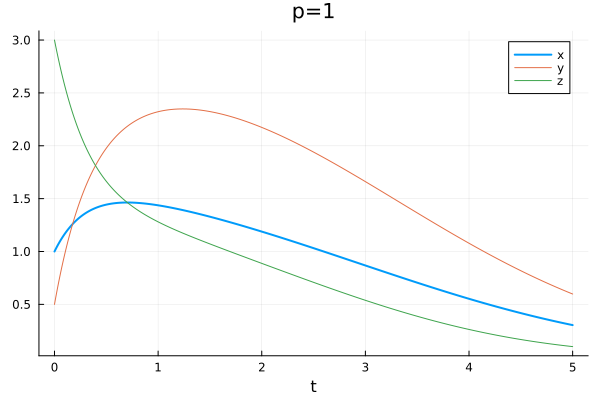

In [131]:
plot(t_', u_[1, :], linewidth = 2, label = "x", title = "p=$ps", xlabel = "t")
plot!(t_', u_[2, :], label = "y")
plot!(t_', u_[3, :], label = "z")

### Creating Additional Loss Function
This function `additional_loss` will have three arguments.

- `phi(x, p)` the trial solution outputed by the neural network $\rightarrow$ `x` is the coordinates vector for the dependent variable and `p` are the weights of the `phi` function
- $\theta$ the parameters of the neural network (weights to be updated during training)
- `p` the hyperparameters of the `OptimizationProblem`

$$ LOSS = \frac{1}{3}\sum_{x, y, z} (\phi_{x, y, z}(t, \theta) - u_{x, y, z})^2$$

In [77]:
# Adding loss term to optimize parameters
depvars = [:x, :y, :z] # : is the symbol operator, here we specify the dependent variables using the Symbol data type

function additional_loss(phi, θ, p)
    return sum(sum(abs2, phi[i](t_, θ[depvars[i]]) .- u_[[i], :]) / len for i in 1:1:3)
end

additional_loss (generic function with 1 method)

### Defining PINN Interface
To define a PINN problem, we use the discretize method. The power of PINNs lies in the residual (loss) function, which is where we inform the network of the underlying physics of the system. The PDE and BC residuals are calculated inside the `discretize` method, and we can access their losses throughout training using the `symbolic_discretize` interface. Progress is displayed through `callback`.

[Configuring Optimization.solve options](https://julianlsolvers.github.io/Optim.jl/v0.9.3/user/config/)

[Discretize github page](https://github.com/SciML/NeuralPDE.jl/blob/c52c7d55d6fe00a78c95c4adb3ea5724c4adefa3/src/discretize.jl#L673-L681)

[For when I attempt to animate the training process again](https://julialang.org/blog/2019/01/fluxdiffeq/)

In [78]:
discretization = NeuralPDE.PhysicsInformedNN([chain1, chain2, chain3], 
                                                NeuralPDE.GridTraining(dt), param_estim = true, 
                                                additional_loss = additional_loss)

@named pde_system = PDESystem(eqs, bcs, domains, [t], [x(t), y(t), z(t)], [α], defaults = Dict([p .=> 0.1 for p in [α]]))

prob = NeuralPDE.discretize(pde_system, discretization)
sym_prob = symbolic_discretize(pde_system, discretization)

pde_inner_loss_functions = sym_prob.loss_functions.pde_loss_functions
bcs_inner_loss_functions = sym_prob.loss_functions.bc_loss_functions

3-element Vector{NeuralPDE.var"#74#75"{loss_function, Matrix{Float64}} where loss_function}:
 #74 (generic function with 1 method)
 #74 (generic function with 1 method)
 #74 (generic function with 1 method)

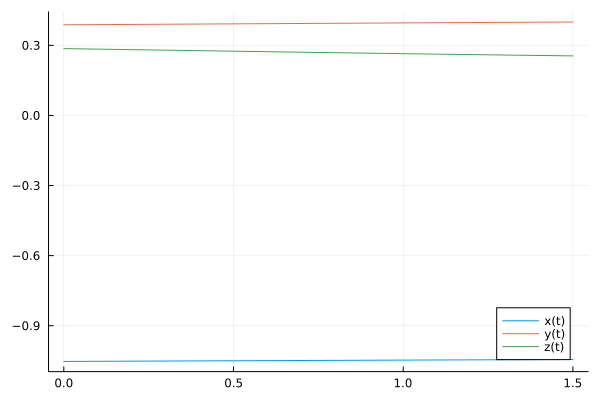

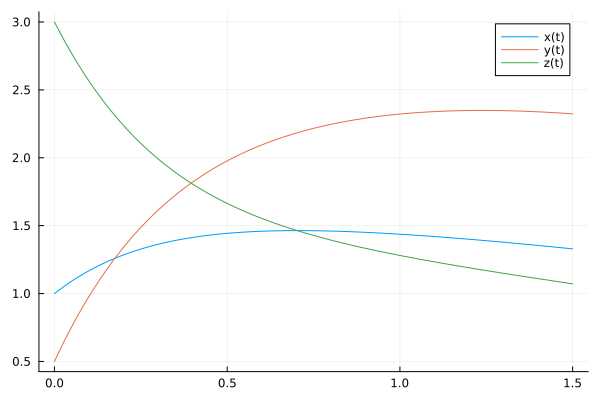

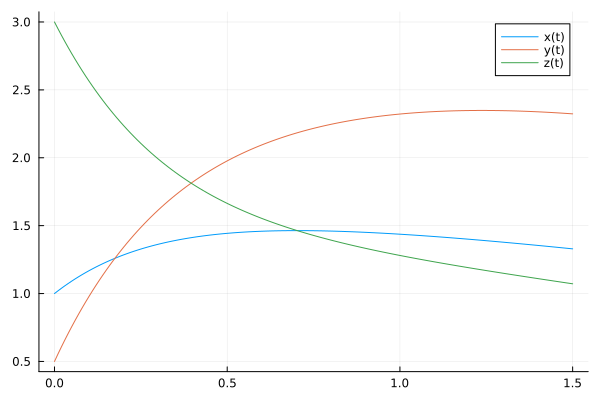

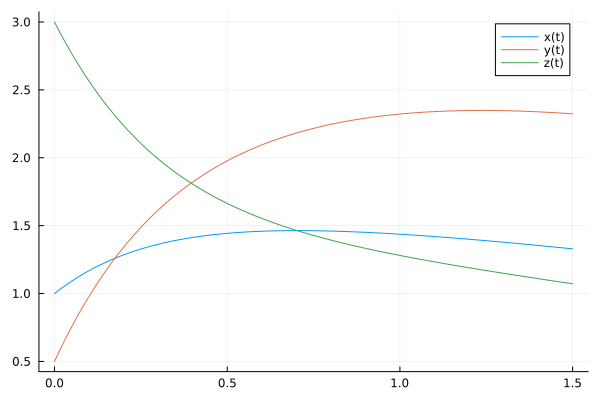

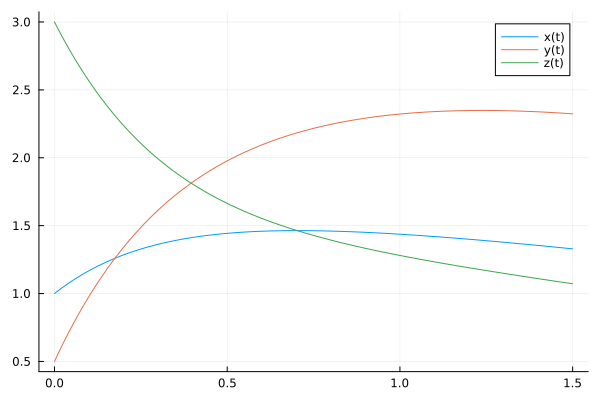

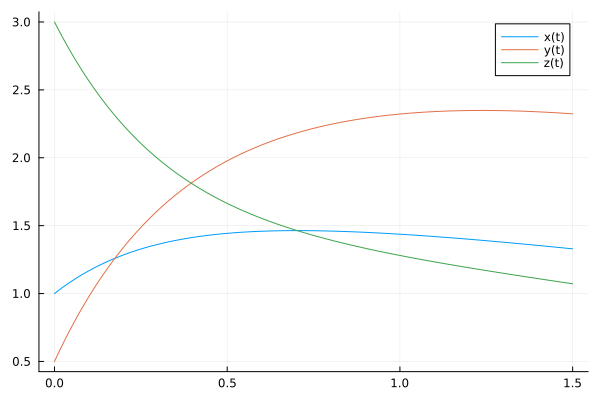

1.0000054293256635

In [79]:
callback = function(p, l)
    # Print losses
    println("loss: ", l)
    println("pde_losses: ", map(l_ -> l_(p), pde_inner_loss_functions))
    println("bcs_losses: ", map(l_ -> l_(p), bcs_inner_loss_functions))
    println()

    # # Visualizing training
    weights = [p.depvar.x, p.depvar.y, p.depvar.z]
    state = [[discretization.phi[i]([t], weights[i])[1] for t in ts] for i in 1:3] 
    display(plot(ts, state, label = ["x(t)" "y(t)" "z(t)"]))

    return false
end

res = Optimization.solve(prob, BFGS(); callback = callback, maxiters = 5000, show_every = 1000)
p_ = res.u[end] # Last layer is optimized parameter

## Visualizing the NN Prediction


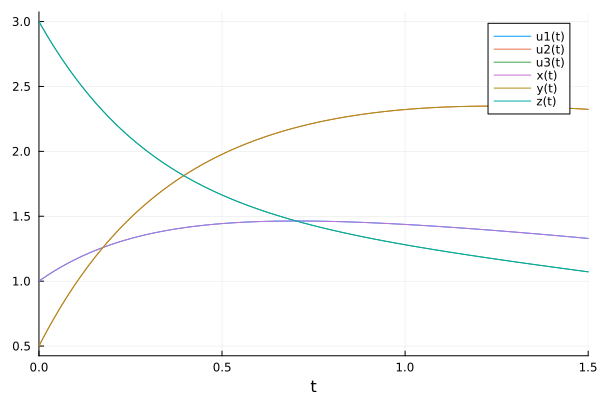

In [108]:
minimizers = [res.u.depvar[depvars[i]] for i in 1:3]                                    # retrieving NN representation (weights and biases) for each dependent variable
ts = [infimum(d.domain):(dt / 10):supremum(d.domain) for d in domains][1]               # time domain
u_predict = [[discretization.phi[i]([t], minimizers[i])[1] for t in ts] for i in 1:3] 
plot(sol)
plot!(ts, u_predict, label = ["x(t)" "y(t)" "z(t)"])

## Extrapolation
The model performs well on the trained time domain. Here, we will make the model extrapolate pass the training domain to rate its performance on an unseen domain.

In [155]:
# Remaking problem on tspan (1.0, 5.0)
newts = (0.0, 5.0)
newprob = remake(prob, tspan=newts)
newsol = solve(newprob, Tsit5(), dt = 0.1)

# Generating predictions for new tspan
domain_test = [t ∈ Interval(0, 5.0)]
ts_test = [infimum(d.domain):(dt / 10):supremum(d.domain) for d in domain_test][1]

# PINN Prediction
u_predict_test = [[discretization.phi[i]([t], minimizers[i])[1] for t in ts_test] for i in 1:3]

3-element Vector{Vector{Float64}}:
 [0.9999783168561327, 1.0019747614660945, 1.0039642305675422, 1.0059467449245176, 1.0079223252505347, 1.0098909922085781, 1.011852766411097, 1.0138076684199957, 1.0157557187466306, 1.0176969378518161  …  0.24787965041766524, 0.24761378885403995, 0.24734799052486722, 0.24708225544648155, 0.24681658363519676, 0.24655097510730872, 0.24628542987908952, 0.2460199479667915, 0.24575452938664744, 0.2454891741548615]
 [0.49997224127361767, 0.5054643994866366, 0.5109411047085695, 0.5164024000558654, 0.5218483285418347, 0.5272789330765868, 0.5326942564669837, 0.5380943414165926, 0.5434792305256495, 0.5488489662910216  …  0.8093509427448328, 0.8090250309173388, 0.8086992363483949, 0.8083735590111235, 0.808047998878632, 0.8077225559240053, 0.807397230120299, 0.8070720214405551, 0.8067469298577872, 0.8064219553449908]
 [2.999966456577812, 2.9949734350753983, 2.9899943789890093, 2.9850292544035284, 2.9800780274273047, 2.9751406641927938, 2.9702171308571845, 2.965307

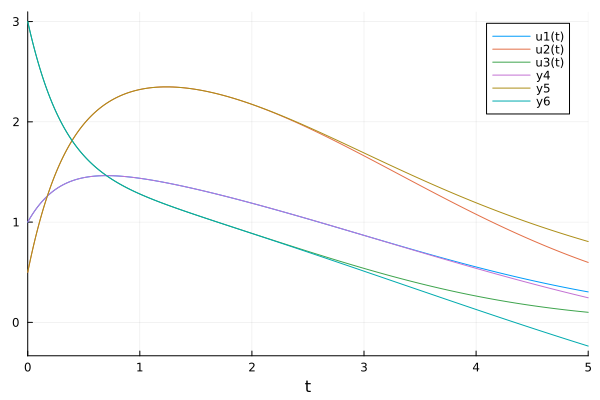

In [156]:
plot(newsol)
plot!(ts_test, u_predict_test)

In [161]:
# Extracting data from newsol
data = getData(newsol, ts_test)
newsol_, newts_ = data

2-element Vector{Matrix{Float64}}:
 [1.0 1.0019965046320243 … 0.30424575812358184 0.3040423097435138; 0.5 0.5054922595226241 … 0.5983740152874689 0.5979772309711626; 3.0 2.9950069941201773 … 0.10075018026339695 0.10064129252395479]
 [0.0 0.001 … 4.999 5.0]

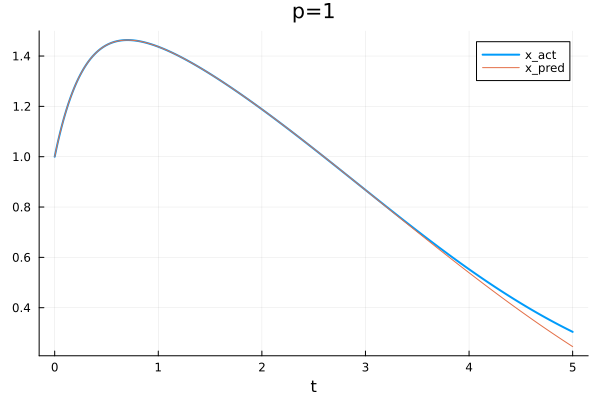

In [167]:
# Comparing x(t)
plot(newts_', newsol_[1, :], linewidth = 2, label = "x_act", title = "p=$ps", xlabel = "t")
plot!(ts_test, u_predict_test[1, :], label = "x_pred")

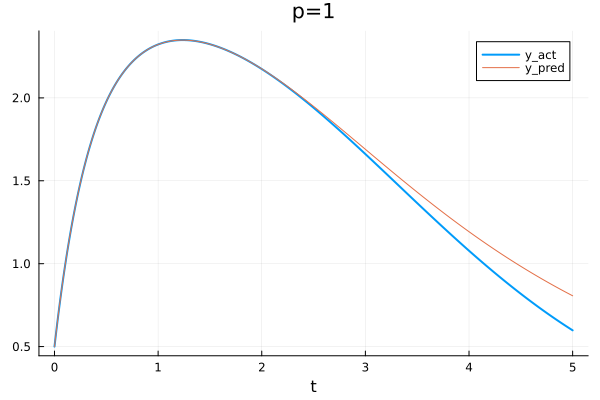

In [168]:
# Comparing y(t)
plot(newts_', newsol_[2, :], linewidth = 2, label = "y_act", title = "p=$ps", xlabel = "t")
plot!(ts_test, u_predict_test[2, :], label = "y_pred")

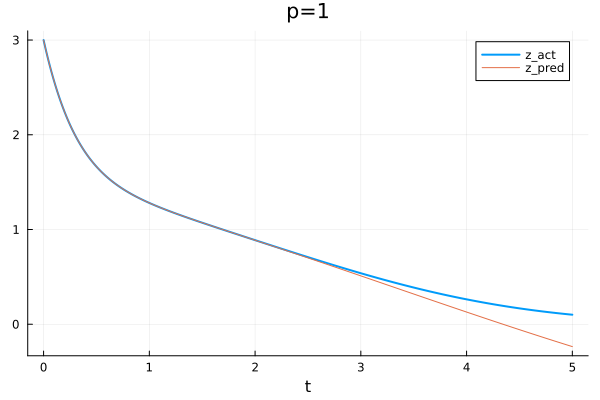

In [169]:
# Comparing z(t)
plot(newts_', newsol_[3, :], linewidth = 2, label = "z_act", title = "p=$ps", xlabel = "t")
plot!(ts_test, u_predict_test[3, :], label = "z_pred")


## Error Analysis

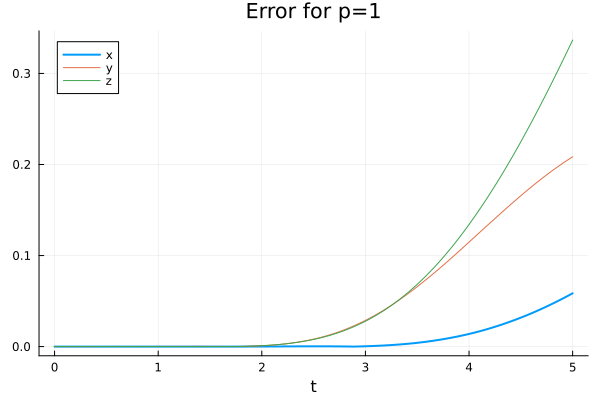

In [184]:
u_pred = hcat(u_predict_test...)'
error = broadcast(abs, (u_pred - newsol_))

plot(ts_test, error[1, :], linewidth = 2, label = "x", title = "Error for p=$ps", xlabel = "t")
plot!(ts_test, error[2, :], label = "y")
plot!(ts_test, error[3, :], label = "z")

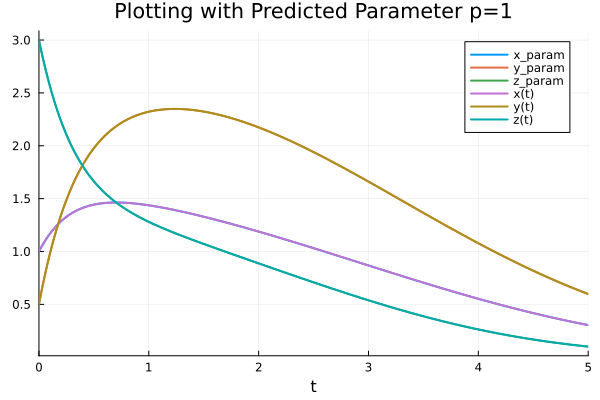

In [190]:
# Remaking problem with predicted parameter
prob_estim = remake(newprob, p=p_)
sol_estim = solve(newprob, Tsit5(), dt = 0.1)

plot(sol_estim, linewidth = 2, label = ["x_param" "y_param" "z_param"], title = "Plotting with Predicted Parameter p=$ps", xlabel = "t")
plot!(newsol, linewidth = 2, label = ["x(t)" "y(t)" "z(t)"], title = "Plotting with Predicted Parameter p=$ps", xlabel = "t")